In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data.dataloader import DataLoader

from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

## Data load

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '/home/projects/bagon/ingap')

100%|██████████| 135107811/135107811 [00:07<00:00, 17979456.43it/s]


## Data Extract

In [3]:
with tarfile.open('/home/projects/bagon/ingap/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='/home/projects/bagon/ingap/cifar10_data')

## Data visualization

In [2]:
data_dir = '/home/projects/bagon/ingap/cifar10_data/cifar10'

In [3]:
classes = os.listdir(data_dir + "/train")
print(classes)

['automobile', 'frog', 'truck', 'horse', 'ship', 'cat', 'dog', 'bird', 'deer', 'airplane']


In [4]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))

No. of training examples for airplanes: 5000


In [5]:
airplane_files_test = os.listdir(data_dir + "/test/airplane")
print('No. of training examples for airplanes TEST:', len(airplane_files_test))

No. of training examples for airplanes TEST: 1000


In [6]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0223.png', '0127.png', '0853.png', '0517.png', '0701.png']


In [7]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [8]:
dataset_test = ImageFolder(data_dir+'/test', transform=ToTensor())

In [9]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [10]:
dataset.classes[label]

'airplane'

In [11]:
img.size()

torch.Size([3, 32, 32])

In [12]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
print(dataset_test.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
# '#ffffff' => representing a color in the RGB (Red, Green, Blue) color system
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [15]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))
    # convert torch.Size([3, 32, 32]) to torch.Size([32, 32, 3])

In [16]:
def show_class(data,start_index):
  img, label = data[start_index]
  print(dataset.classes[label])
  plt.figure(figsize=(11, 4))
  for i in range(start_index, start_index+10):
    img, label = data[i]
    
    plt.subplot(1,10,i+1-start_index)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
  plt.show()

## Images of training set

airplane


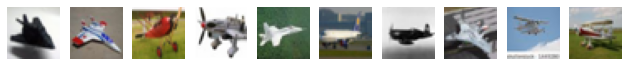

automobile


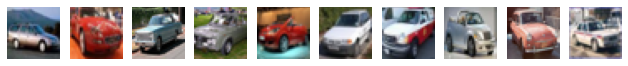

bird


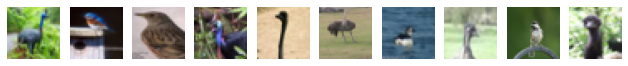

cat


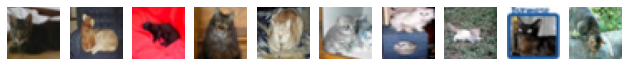

deer


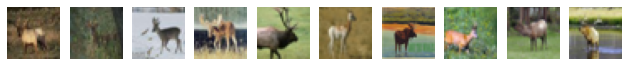

dog


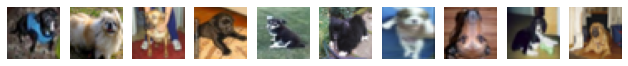

frog


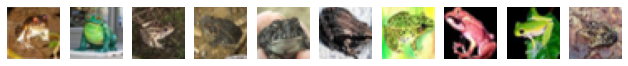

horse


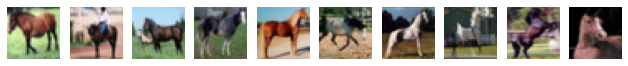

ship


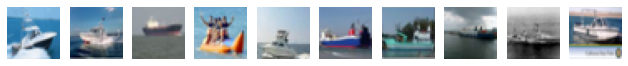

truck


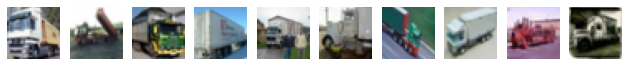

In [17]:
for i in range (0,50000,5000):
  show_class(dataset,i)

## Images of trest set

airplane


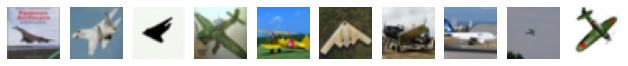

automobile


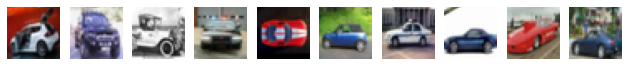

bird


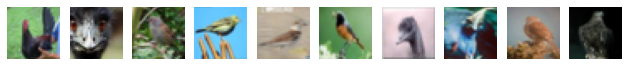

cat


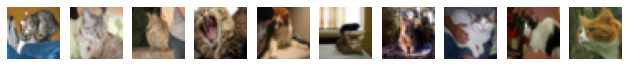

deer


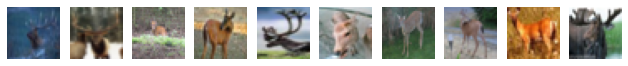

dog


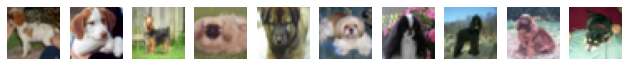

frog


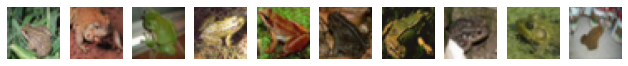

horse


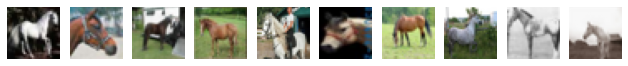

ship


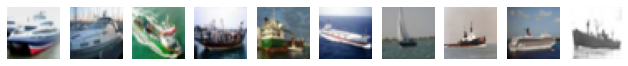

truck


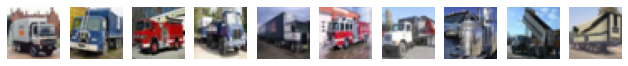

In [18]:
for i in range (0,10000,1000):
  show_class(dataset_test,i)

## Limiting randomness

https://pytorch.org/docs/stable/notes/randomness.html

In [19]:
random_seed = 42 # for custom operators

torch.manual_seed(random_seed) # for torch
np.random.seed(random_seed) # for NumPy libraries

# Use deterministic algorithms only
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(True)

# Use deterministric convolution algorithm in CUDA
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [20]:
# Fix workers randomness
import random

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(random_seed)

## Train/Validation random split

In [21]:
val_size = 5000
train_size = len(dataset) - val_size
train_size

45000

In [22]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [23]:
train_ds[0]

(tensor([[[0.5176, 0.5294, 0.4588,  ..., 0.4980, 0.4902, 0.5294],
          [0.4471, 0.3451, 0.3098,  ..., 0.4549, 0.4314, 0.5333],
          [0.5098, 0.1882, 0.1882,  ..., 0.4941, 0.4667, 0.5804],
          ...,
          [0.4510, 0.5804, 0.5725,  ..., 0.3647, 0.5529, 0.7569],
          [0.4863, 0.5451, 0.6392,  ..., 0.6549, 0.7529, 0.8627],
          [0.7294, 0.7216, 0.7490,  ..., 0.8471, 0.8235, 0.8588]],
 
         [[0.4941, 0.4941, 0.4078,  ..., 0.4706, 0.4784, 0.5216],
          [0.4157, 0.2980, 0.2471,  ..., 0.4235, 0.4157, 0.5255],
          [0.4706, 0.1333, 0.1137,  ..., 0.4627, 0.4510, 0.5725],
          ...,
          [0.4157, 0.5451, 0.5373,  ..., 0.2941, 0.4863, 0.6941],
          [0.4431, 0.5020, 0.5922,  ..., 0.5608, 0.6627, 0.7804],
          [0.6784, 0.6667, 0.6863,  ..., 0.7451, 0.7216, 0.7608]],
 
         [[0.4588, 0.4784, 0.4118,  ..., 0.4667, 0.4667, 0.5098],
          [0.3843, 0.2863, 0.2549,  ..., 0.4275, 0.4157, 0.5216],
          [0.4392, 0.1255, 0.1255,  ...,

In [24]:
img, label = train_ds[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 7


In [25]:
print('Label: ', dataset.classes[label], "(" + str(label) + ")")

Label:  horse (7)


Label:  horse (7)


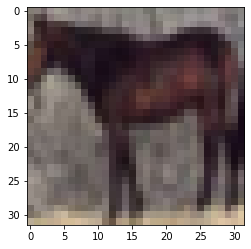

In [26]:
show_example(*train_ds[0])

## DataLoaders

In [27]:
batch_size=128

In [28]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True, generator=g, worker_init_fn=seed_worker)
# Pinned memory is a special kind of memory in the host (CPU) that is never swapped out or moved by the operating system

In [29]:
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True, generator=g, worker_init_fn=seed_worker)
# ? why batch size is different?
# ? why shuffle is not TRUE?

In [30]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

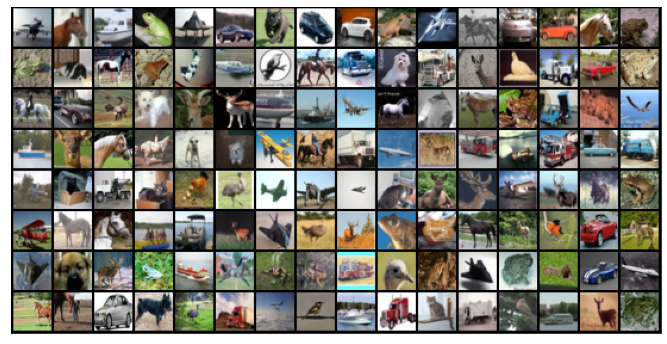

In [31]:
show_batch(train_dl)

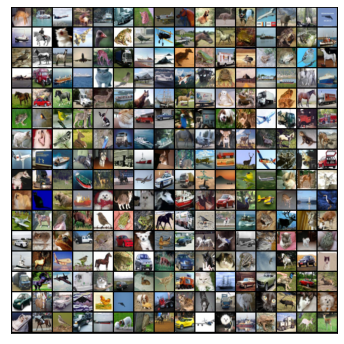

In [32]:
show_batch(val_dl)

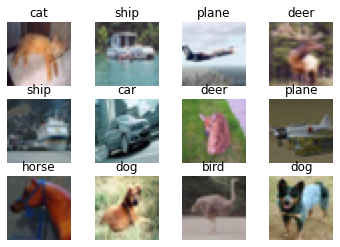

In [33]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

for i in range(0, 12):
    img, label = val_ds[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

## Model

In [34]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [36]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [37]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0196,  0.0413, -0.0258, -0.0371,  0.0457, -0.0270, -0.0140,  0.0326,
         0.0287,  0.0191], grad_fn=<SelectBackward0>)


## Device

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [40]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
train_dl = DeviceDataLoader(train_dl, device)

In [43]:
val_dl = DeviceDataLoader(val_dl, device)

In [44]:
to_device(model, device);

## Train the model

In [45]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [46]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
model = to_device(Cifar10CnnModel(), device)
model2 = to_device(Cifar10CnnModel(), device)

In [54]:
evaluate(model, val_dl)

{'val_loss': 2.303372621536255, 'val_acc': 0.10296414792537689}

In [55]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [56]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7647, val_loss: 1.4399, val_acc: 0.4706
Epoch [1], train_loss: 1.2625, val_loss: 1.1122, val_acc: 0.5882
Epoch [2], train_loss: 0.9858, val_loss: 0.9061, val_acc: 0.6830
Epoch [3], train_loss: 0.8070, val_loss: 0.8199, val_acc: 0.7113
Epoch [4], train_loss: 0.6647, val_loss: 0.8062, val_acc: 0.7254
Epoch [5], train_loss: 0.5467, val_loss: 0.7329, val_acc: 0.7544
Epoch [6], train_loss: 0.4366, val_loss: 0.7452, val_acc: 0.7573
Epoch [7], train_loss: 0.3383, val_loss: 0.7571, val_acc: 0.7610
Epoch [8], train_loss: 0.2551, val_loss: 0.7881, val_acc: 0.7714
Epoch [9], train_loss: 0.1948, val_loss: 0.9076, val_acc: 0.7627


### reproducibility

In [57]:
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8681, val_loss: 1.4924, val_acc: 0.4510
Epoch [1], train_loss: 1.2973, val_loss: 1.1510, val_acc: 0.5877
Epoch [2], train_loss: 1.0135, val_loss: 0.9804, val_acc: 0.6581
Epoch [3], train_loss: 0.8497, val_loss: 0.8506, val_acc: 0.7009
Epoch [4], train_loss: 0.7315, val_loss: 0.8078, val_acc: 0.7172
Epoch [5], train_loss: 0.6234, val_loss: 0.7662, val_acc: 0.7278
Epoch [6], train_loss: 0.5397, val_loss: 0.7456, val_acc: 0.7458
Epoch [7], train_loss: 0.4685, val_loss: 0.7445, val_acc: 0.7509
Epoch [8], train_loss: 0.3890, val_loss: 0.7616, val_acc: 0.7623
Epoch [9], train_loss: 0.3297, val_loss: 0.7994, val_acc: 0.7599


In [73]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

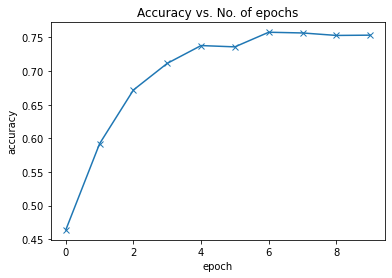

In [74]:
plot_accuracies(history)

In [75]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

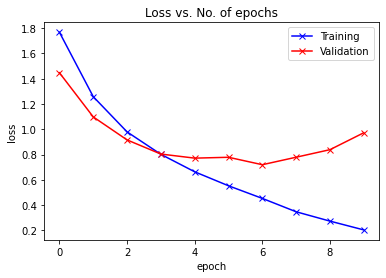

In [76]:
plot_losses(history)

## Test analysis

In [78]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [77]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


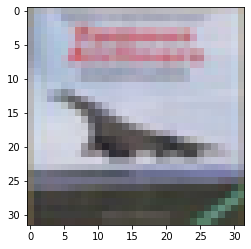

In [79]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: truck


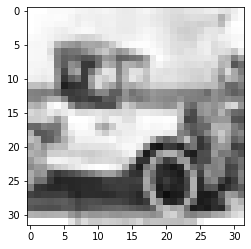

In [80]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


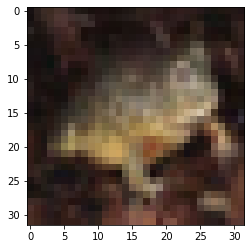

In [81]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [82]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.0003304481506348, 'val_acc': 0.7520507574081421}

## Save the model

In [83]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

## Load model

In [84]:
model2 = to_device(Cifar10CnnModel(), device)

In [85]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [86]:
evaluate(model2, test_loader)

{'val_loss': 1.0003304481506348, 'val_acc': 0.7520507574081421}

In [ ]:
colorjiggle,randomaffine, randomverticalflip, randomhorizontalflip, randomrotation, randomerasing, randomgrayscale, randomresizedcrop, centercrop
